<a href="https://colab.research.google.com/github/Boduck/Data-Analysis/blob/main/%EC%BB%A4%EB%A8%B8%EC%8A%A4%EB%8D%B0%EC%9D%B4%ED%84%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#커머스 데이터 분석
---

1. 데이터 결합 및 시각화
2. 재구매 유도 캠페인 성과 분석
3. RFM기반 고가치고객 매출 증진 전략

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 0. SETTING

In [ ]:
#보유 데이터
cust = pd.read_csv('./Customer.csv')   #고객 인적정보
category = pd.read_csv('./prod_cat_info.csv')   #카테고리 코드/명칭
t_act = pd.read_csv('./Transactions.csv')   #거래내역
#
company = pd.read_csv('./50_Startups.csv')
#데이터 병합(cust, category, t_act)
merged = pd.read_csv('./merge_trans_cust_prod.csv')

[데이터 설명]

**Customer.csv : 고객의 인적 정보를 담고 있는 데이터 (고객id, 생년월일, 성별, 거주지 코드)**

- customer_id : 고객id (고객 식별 값, 보통 고유함)
- DOB : 고객 생년월일 (날짜 형식 데이터)
- Gender : 고객 성별 (M : 남성 / F : 여성)
- city_code : 거주지 코드 (1부터 10까지 숫자로 구성)

**Transactions.csv : 거래 내역 데이터 (고객id, 주문id, 거래 일자, 카테고리 콛, 거래 금액 등)**
- transaction_id : 거래id (거래 발생 시 부여되는 번호)
- cust_id : 고객id (Customer의 customer_id와 동일)
- tran_date : 거래 일자 (날짜 형식 데이터)
- prod_sub_cat_code : 서브 카테고리 코드 (숫자 구성)
- prod_cat_code : 대 카테고리 코드 (숫자 구성)
- Qty : 주문 수량 (음수로 기록된 데이터도 존재)
- Rate : 판매 금액 (음수로 기록된 데이터도 존재)
- Tax : 세금 (음수로 기록된 데이터에도 양수로 기록됨)
- total_amt : 거래 금액 (판매 금액 x 주문 수량 + 세금)
- Store_type : 거래가 발생한 판매 채널 타입 (e-shop, TeleShop, Flagship store, MBR)

**prod_cat_info : 카테고리 코드/명칭 데이터 (대 카테고리 코드/명칭, 서브 카테고리 코드/명칭)**
- prod_cat_code : 대 카테고리 코드 (Transactions 데이터에도 존재)
- prod_cat : 대 카테고리 명칭
- prod_sub_cat_code : 서브 카테고리 코드 (Transactions 데이터에도 존재)
- prod_subcat : 서브 카테고리 명칭

In [ ]:
# 오늘 날짜
# today_date = pd.to_datetime('2014-03')

# 1. 데이터 탐색(EDA)

In [ ]:
print(f'''
데이터 형태 : {merged.shape}
거래 데이터 기간 : {merged['tran_date'].min()} ~ {merged['tran_date'].max()}
데이터 내 총 고객 수 : {merged['cust_id'].nunique()}명
''')


데이터 형태 : (22933, 18)
거래 데이터 기간 : 2011-01-25 ~ 2014-02-28
데이터 내 총 고객 수 : 5506명



In [ ]:
#데이터 속성 확인
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22933 entries, 0 to 22932
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cust_id            22933 non-null  int64  
 1   dob                22933 non-null  object 
 2   age                22933 non-null  int64  
 3   gender             22933 non-null  object 
 4   city_code          22933 non-null  float64
 5   order_status       22933 non-null  object 
 6   confirmed_yn       22933 non-null  float64
 7   transaction_id     22933 non-null  int64  
 8   tran_date          22933 non-null  object 
 9   prod_cat_code      22933 non-null  int64  
 10  prod_sub_cat_code  22933 non-null  int64  
 11  prod_cat           22933 non-null  object 
 12  prod_subcat        22933 non-null  object 
 13  qty                22933 non-null  int64  
 14  rate               22933 non-null  int64  
 15  tax                22933 non-null  float64
 16  total_amt          229

- 거래일자(tran_date) datetime형 변환의 필요성
- 결측치 없음을 확인
- 범주형 변수 : gender, order_status, prod_cat, prod_subcat, store_type

In [ ]:
# 범주형 변수들 값 확인
obj_col = merged[['gender', 'order_status', 'prod_cat', 'prod_subcat', 'store_type']]
for col in obj_col.columns:
    print(col,':',merged[col].unique().tolist())

gender : ['M', 'F', 'unknown']
order_status : ['Ordered', 'Canceled']
prod_cat : ['Home and kitchen', 'Books', 'Bags', 'Clothing', 'Footwear', 'Electronics']
prod_subcat : ['Bath', 'Academic', 'Women', 'Mens', 'Tools', 'Fiction', 'DIY', 'Kitchen', 'Non-Fiction', 'Kids', 'Mobiles', 'Audio and video', 'Comics', 'Computers', 'Furnishing', 'Children', 'Personal Appliances', 'Cameras']
store_type : ['e-Shop', 'MBR', 'Flagship store', 'TeleShop']


In [ ]:
# 상수 확인
for col in merged.columns:
    if merged[col].nunique()==1:
        print(col)

# 2. 데이터 전처리
---
1. 형 변환


2. 파생 변수 생성
    - 2013년 2월 28일을 기준으로 각 고객의 구매 경과일수 및 구매주기 변수 생성
    - 별도의 데이터 프레임으로 생성
    - 구매 경과일수 = 기준일 - 마지막 구매일
    - 구매주기 = (마지막 구매일 - 첫 구매일)/(총 구매 일수 - 1)


3. 성별이 unknown인 경우 제외

## 형 변환 및 파생변수 생성

In [ ]:
df = merged.copy()

# 형 변환
df['tran_date'] = pd.to_datetime(df['tran_date'])

#성별이 unknown인 별도로 데이터 프레임화
unknown = df[df['gender'] == 'unknown']
known = df[df['gender'] != 'unknown']

# 파생 변수 (구매 경과 일수, 구매주기) 생성
baseline = pd.to_datetime('2013-02-28')
bef_230228 = known.loc[known['tran_date']<= baseline]
aft_230228 = known.loc[known['tran_date']> baseline]

first_purchase = bef_230228.groupby('cust_id')['tran_date'].min() #각 고객의 첫 구매일
last_purchase = bef_230228.groupby('cust_id')['tran_date'].max() #각 고객의 마지막 구매일

total_purchase = bef_230228.groupby('cust_id')['tran_date'].nunique() #각 고객의 총 구매 일수

# 구매 경과일수와 구매주기를 계산하여 새로운 컬럼으로 추가(같은 cust_id는 모두 동일한 값이 됨)
# 거래 데이터가 1개인 경우, 구매주기는 0days
bef_230228['구매경과일수'] = bef_230228.apply(lambda row: (baseline - last_purchase[row['cust_id']]).days, axis=1)
bef_230228['구매주기'] = bef_230228.apply(lambda row: (last_purchase[row['cust_id']] - first_purchase[row['cust_id']]) / (total_purchase[row['cust_id']] - 1) if total_purchase[row['cust_id']] > 1 else pd.Timedelta(days=0), axis=1)

# 3. Data analysis
---
1. 성별, 연령 구간별 고객 수 시각화
    - 연령 최소 최댓값 기준으로 5세 단위로 구간화
    - 성별이 unknown인 경우는 제외
    - cust_id를 중복 카운트하지 않도록 주의
    
    
2. 특정 연령 구간, 성별 간 구매 경과 일수 및 구매주기 차이 여부 확인
    - 고객 고유의 특성을 고려하여, 동일 cust_id에 대하여 연령 구간은 최빈값으로 대체
    - 정확한 구매 주기에 대한 정보를 확인하기 위해, 거래 데이터가 1개인 경우는 배제


3. 전체 데이터 요일별 구매 건수 차이 확인


4. 재구매 유도 캠페인 시행 효과 분석


5. 카테고리 분석
    - 2011년부터 2013년 월평균 매출액이 가장 높은 대 카테고리
    - 각 카테고리별 월평균 매출액의 분산과 표준 편차 확인 및 시각화
    - 변동 계수를 활용한 성과 판단

## 1) 성별, 연령 구간별 고객 수 시각화

In [ ]:
# 5세 단위로 연령 구간 나누기
min_age = bef_230228['age'].min()
max_age = bef_230228['age'].max()

age_intervals = list(range(min_age, max_age + 1, 5))
age_labels = [f'{start}-{start + 4}' for start in age_intervals] # 각 연령 구간에 라벨 붙이기
bef_230228['Age_Group'] = pd.cut(bef_230228['age'], bins=age_intervals + [np.inf], labels=age_labels, right=False)

#성별, 연령 구간별 고객 수
customer_count = bef_230228.groupby(['gender', 'Age_Group'])['cust_id'].nunique().reset_index(name='Customer_Count')
customer_count

,gender,Age_Group,Customer_Count
0,F,19-23,527
1,F,24-28,621
2,F,29-33,633
3,F,34-38,615
4,F,39-43,425
5,M,19-23,546
6,M,24-28,669
7,M,29-33,683
8,M,34-38,647
9,M,39-43,453


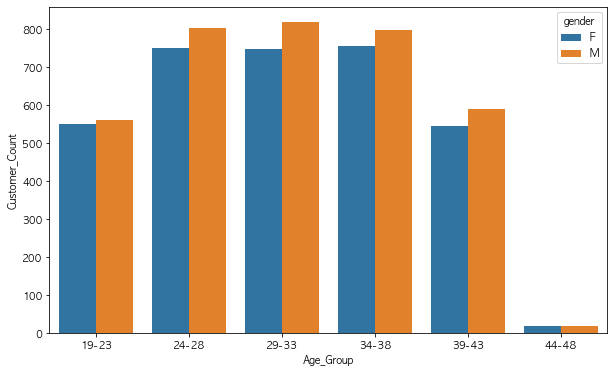

In [ ]:
# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Age_Group', y='Customer_Count', hue='gender', data=customer_count)
plt.show()

## 2) 특정 연령 구간, 성별 간 구매 경과 일수 및 구매주기 차이 여부

In [ ]:
# 연령구간
tmp = bef_230228[['cust_id','gender','Age_Group','구매경과일수','구매주기']]

tmp['Age_Group'] = tmp.groupby('cust_id')['Age_Group'].transform(lambda x: x.mode()[0])
tmp.drop_duplicates(inplace=True)
tmp.shape

(5187, 5)

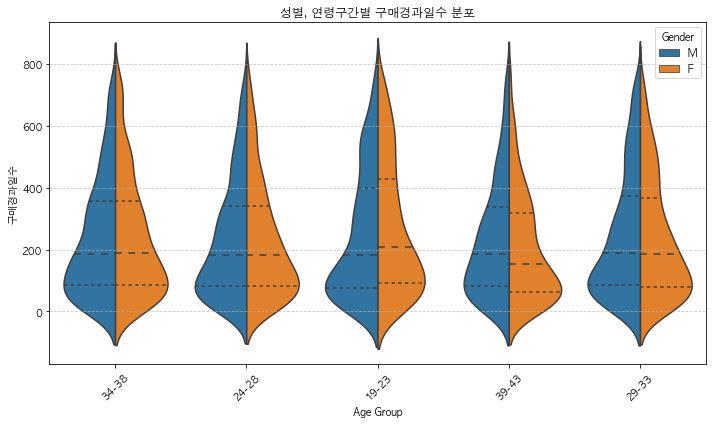

In [ ]:
# 성별, 연령구간별 구매경과일수 바이올린 플롯
plt.figure(figsize=(10, 6))
sns.violinplot(x='Age_Group', y='구매경과일수', hue='gender', data=tmp, split=True, inner='quartile')
plt.title('성별, 연령구간별 구매경과일수 분포')
plt.xlabel('Age Group')
plt.ylabel('구매경과일수')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

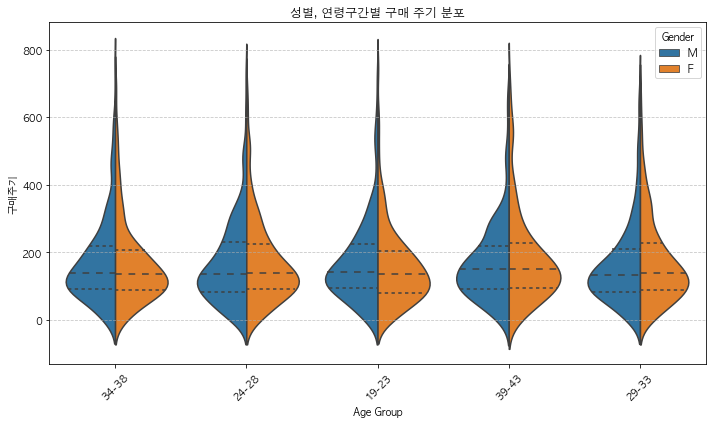

In [ ]:
# 성별, 연령구간별 구매주기 바이올린 플롯
tmp['구매주기'] = tmp['구매주기'].dt.days
temp = tmp.copy()
temp = temp.loc[temp['구매주기']!=0]

plt.figure(figsize=(10, 6))
sns.violinplot(x='Age_Group', y='구매주기', hue='gender', data=temp, split=True, inner='quartile')
plt.title('성별, 연령구간별 구매 주기 분포')
plt.xlabel('Age Group')
plt.ylabel('구매주기')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 3) 전체 데이터 요일별 구매 건수 차이 확인

<AxesSubplot:xlabel='weekday', ylabel='count'>

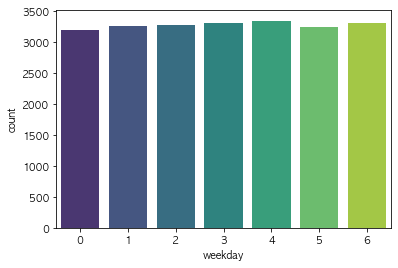

In [ ]:
entire = df.copy()
entire['weekday'] = entire['tran_date'].dt.weekday #요일변수 생성(0~6)

weekday_cnt = entire[['transaction_id','weekday']].groupby('weekday').size().reset_index(name='count')
sns.barplot(x='weekday', y='count', data=weekday_cnt, palette='viridis')

- 요일별 구매건수에 있어서 유의미한 차이가 확인되지 않음

## 4) 재구매 유도 캠페인 성과 분석
---
2013년 2월 28일을 기준으로, 구매 경과 일수가 30일 이상인 고객을 대상으로 재구매 유도 캠페인을 진행


2013년 12월 31일까지 구매 반응한 고객 수 확인

In [ ]:
# '구매 경과 일수' 컬럼의 값이 30 이상인 'cust_id' 추출
selected_cust_id = bef_230228[bef_230228['구매경과일수'] >= 30]['cust_id'].unique()

# 230228 이후 거래 데이터에서(aft_230228) 'selected_cust_id'에 해당하는 'cust_id'가 있는지 확인
is_in_aft_230228 = aft_230228['cust_id'].isin(selected_cust_id)

selected_cust_id_in_aft_230228 = aft_230228.loc[is_in_aft_230228, 'cust_id'].unique()

print(f'총 {len(selected_cust_id)}명 중 {len(selected_cust_id_in_aft_230228)}명이 구매 반응을 보였다.')

총 4673명 중 3241명이 구매 반응을 보였다.


## 5) 카테고리 분석
---
1. 2011년부터 2013년 월평균 매출액이 가장 높은 대 카테고리
    - canceled 데이터 제외
    - 2014년 이전 데이터만 확인
    
    
2. 각 카테고리별 월평균 매출액의 분산과 표준 편차
    - 시각화
    - 변동 계수를 활용한 성과 판단

In [ ]:
tmp = df.copy()
tmp = tmp.loc[tmp['tran_date'].dt.year < 2014]
tmp = tmp.loc[tmp['order_status'] != 'Canceled'] #canceled 데이터 제외
tmp = tmp[['tran_date','prod_cat','prod_cat_code','total_amt']]

#### 2011년부터 2013년 월평균 매출액이 가장 높은 대 카테고리

In [ ]:
# 연도와 월 추출
tmp['tran_year'] = tmp['tran_date'].dt.year
tmp['tran_month'] = tmp['tran_date'].dt.month

# # 대카테고리/연/월 구분에 따른 매출액 합계
monthly_sales = tmp.groupby(['prod_cat', 'prod_cat_code', 'tran_year', 'tran_month'])['total_amt'].sum().reset_index()

# 위 합계를 연도별 평균으로
avg_monthly_sales = monthly_sales.groupby(['prod_cat', 'prod_cat_code', 'tran_year'])['total_amt'].mean().reset_index()

# 가장 높은 월평균 매출액을 가진 대 카테고리 찾기
max_avg_sales_cat = avg_monthly_sales.loc[avg_monthly_sales.groupby('tran_year')['total_amt'].idxmax()]

print("연도별 월평균 매출액이 가장 높은 대 카테고리:\n")
max_avg_sales_cat

연도별 월평균 매출액이 가장 높은 대 카테고리:



,prod_cat,prod_cat_code,tran_year,total_amt
3,Books,5,2011,372307.189583
4,Books,5,2012,401357.547500
5,Books,5,2013,368940.899167


- 3년 동안 월평균 매출액이 가장 높은 대카테고리 항목은 Books

#### 각 카테고리별 월평균 매출액의 분산과 표준 편차

In [ ]:
variance_std_dev = avg_monthly_sales.groupby('prod_cat')['total_amt'].agg(['var', 'std'])

formatted_result = variance_std_dev.applymap(lambda x: '{:,.2f}'.format(x))

print("각 카테고리별 월평균 매출액의 분산과 표준 편차:\n")
formatted_result

각 카테고리별 월평균 매출액의 분산과 표준 편차:



,var,std
prod_cat,,
Bags,"4,231,821.30","2,057.14"
Books,"317,682,382.57","17,823.65"
Clothing,"262,253,772.47","16,194.25"
Electronics,"120,571,856.34","10,980.52"
Footwear,"196,323,312.95","14,011.54"
Home and kitchen,"90,817,577.73","9,529.83"


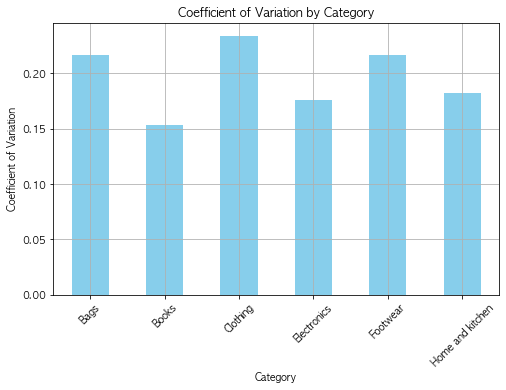

In [ ]:
# 대 카테고리 별로 월평균 매출액과 표준 편차 계산
avg_monthly_sales = monthly_sales.groupby('prod_cat')['total_amt'].mean()
std_monthly_sales = monthly_sales.groupby('prod_cat')['total_amt'].std()

# 변동 계수 계산
coefficient_of_variation = std_monthly_sales / avg_monthly_sales

# 시각화
plt.figure(figsize=(8, 5))
coefficient_of_variation.plot(kind='bar', color='skyblue')
plt.title('Coefficient of Variation by Category')
plt.xlabel('Category')
plt.ylabel('Coefficient of Variation')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

1. 낮은 변동 계수 (안정적인 성과):

- 변동 계수가 낮은 카테고리는 매출액이 일정하게 안정적으로 유지되고 있음을 나타냅니다.
- 이러한 카테고리의 경우 예측이 비교적 쉽고, 경영에 안정성을 제공할 수 있습니다.
2. 높은 변동 계수 (변동성이 큰 성과):

- 변동 계수가 높은 카테고리는 매출액의 변동이 크다는 것을 의미합니다.
- 이러한 카테고리는 예측이 어려울 수 있으며, 경영에 불안정성을 초래할 수 있습니다.
- 그러나 높은 변동성은 높은 수익 가능성을 나타낼 수도 있으므로, 적절한 리스크 관리와 함께 적극적인 전략 수립이 필요합니다.

# 4. Interpretation & Hypothesising
---
**[매출 관점에서 카테고리별 매출 성장 방안]**

0. Canceled 데이터 제외


1. 충성 고객
- 고객별 구매액 분포 확인 -> 중앙값 이상의 구매액
- 한번 거래한 고객 제외한 구매주기 분포 확인 -> 중앙값 이하의 구매 주기

2. 카테고리별로 판매에 강점이 있는 판매 채널이 있을 것으로 추정됨.

**[고객 관점에서 구매 활동성 증대 방안]**

- RFM분석 기반 고가치고객의 매출 증진 전략
- 거래건수가 적은 고객들 대상 공통 요인 파악

Text(0.5, 1.0, '고객별 총 거래금액 분포')

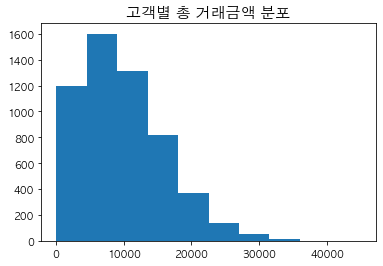

In [ ]:
df = df.loc[df['order_status'] != 'Canceled']

cust_total = df.groupby(['cust_id'])['total_amt'].sum()
plt.hist(cust_total)
plt.title('고객별 총 거래금액 분포', fontsize=15)

Text(0.5, 1.0, '구매주기 분포')

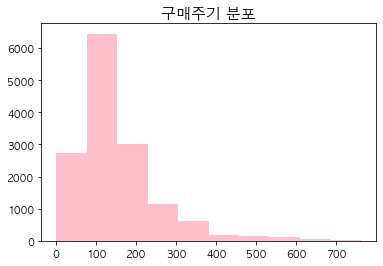

In [ ]:
# 총 1번 구매한 사람 제외한 구매주기 분포 확인
bef_230228['구매주기'] = bef_230228['구매주기'].dt.days
bef_230228 = bef_230228.loc[bef_230228['구매주기']!=0]
plt.hist(bef_230228['구매주기'], color='pink')
plt.title('구매주기 분포', fontsize=15)

In [ ]:
cust_total_median = cust_total.median()
cust_id_above_median = cust_total[cust_total >= cust_total_median].index.tolist()

cycle_median = bef_230228.groupby('cust_id')['구매주기'].median()
cust_id_below_median = cycle_median[cycle_median <= cycle_median.median()].index.tolist()

# 공통된 cust_id 찾기
loyal_cust = set(cust_id_above_median) & set(cust_id_below_median)
print(f'총 {len(loyal_cust)}명을 충성 고객으로 분류하여 데이터 탐색\n')


loyal_df = df[df['cust_id'].isin(loyal_cust)].reset_index(drop=True)


총 1359명을 충성 고객으로 분류하여 데이터 탐색



In [ ]:
loyal_df.groupby(['store_type'])['total_amt'].sum().reset_index()

,store_type,total_amt
0,Flagship store,4254209.115
1,MBR,4314650.405
2,TeleShop,4025624.395
3,e-Shop,8790310.360


In [ ]:
#고객 관점에서 구매 활동성 증대 방안
transaction_count = df.groupby('cust_id')['transaction_id'].count()

Text(0.5, 1.0, '고객별 총 거래 건수 분포')

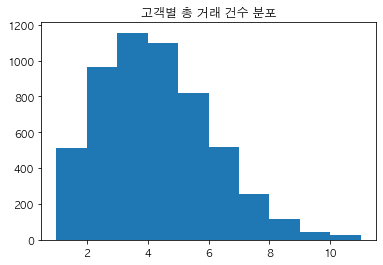

In [ ]:
plt.hist(transaction_count)
plt.title('고객별 총 거래 건수 분포')

In [ ]:
few_id= transaction_count.loc[transaction_count==1].index.tolist()

In [ ]:
few_df = df.loc[df.cust_id.isin(few_id)]
few_df.drop('order_status', axis=1, inplace = True)

In [ ]:
obj_col = few_df[['gender','confirmed_yn', 'prod_cat', 'prod_subcat', 'store_type']]
for col in obj_col.columns:
    print(col,':\n',obj_col[col].value_counts(),'\n')

gender :
 M    270
F    241
Name: gender, dtype: int64 

confirmed_yn :
 1.0    463
0.0     48
Name: confirmed_yn, dtype: int64 

prod_cat :
 Books               134
Electronics         112
Home and kitchen     99
Footwear             61
Clothing             57
Bags                 48
Name: prod_cat, dtype: int64 

prod_subcat :
 Women                  69
Mens                   55
Kids                   42
Tools                  31
Kitchen                29
DIY                    26
Computers              25
Audio and video        24
Personal Appliances    24
Comics                 24
Non-Fiction            23
Children               21
Bath                   21
Cameras                21
Academic               20
Fiction                20
Mobiles                18
Furnishing             18
Name: prod_subcat, dtype: int64 

store_type :
 e-Shop            224
Flagship store    103
MBR                99
TeleShop           85
Name: store_type, dtype: int64 



## 고객 관점에서 구매 활동성 증대 방안 : RFM분석 기반 고가치고객의 매출 증진 전략

## 고가치 고객 정의

In [ ]:
#고객별 매출액 구하기
df_customer_monetary = df_transaction.groupby('cust_id').sum()['total_amt'].reset_index()
df_customer_monetary = df_customer_monetary.rename(columns = {'total_amt' : 'monetary'})

<ipython-input-133-ddd7703771a8>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_customer_monetary = df_transaction.groupby('cust_id').sum()['total_amt'].reset_index()


In [ ]:
df_rfm_raw = pd.merge(df_customer_purchase, df_customer_monetary, on = 'cust_id')
df_rfm_raw

,cust_id,last_purchase_date,first_purchase_date,total_purchase_days,purchase_elapsed_days,purchase_frequency,customer_Id,Gender,city_code,date_birth,age,age_group,monetary
0,266783,2013-02-20,2011-09-23,5,8,129.0,266783,M,4.0,1974-05-01,37,"[34, 39)",3113.890
1,266784,2012-12-04,2012-08-23,3,86,51.0,266784,F,10.0,1991-12-13,20,"[19, 24)",5694.065
2,266785,2013-02-13,2011-03-15,7,15,116.0,266785,F,3.0,1985-06-29,26,"[24, 29)",21613.800
3,266788,2013-02-12,2011-06-12,4,16,203.0,266788,F,2.0,1972-03-20,39,"[39, 44)",6092.970
4,266794,2012-11-27,2011-03-18,9,93,77.0,266794,F,9.0,1971-02-28,40,"[39, 44)",27981.915
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5184,275257,2013-02-26,2011-12-05,3,2,224.0,275257,M,5.0,1987-10-25,24,"[24, 29)",12574.900
5185,275261,2011-10-05,2011-09-26,2,512,9.0,275261,F,10.0,1973-03-21,38,"[34, 39)",442.000
5186,275262,2012-02-29,2011-08-13,2,365,200.0,275262,M,10.0,1973-06-06,38,"[34, 39)",5078.580
5187,275264,2011-10-08,2011-08-05,2,509,64.0,275264,M,4.0,1991-10-24,20,"[19, 24)",3815.565


In [ ]:
df_rfm = df_rfm_raw[['cust_id', 'purchase_elapsed_days', 'purchase_frequency', 'monetary', 'Gender', 'city_code', 'age', 'age_group']]
df_rfm

,cust_id,purchase_elapsed_days,purchase_frequency,monetary,Gender,city_code,age,age_group
0,266783,8,129.0,3113.890,M,4.0,37,"[34, 39)"
1,266784,86,51.0,5694.065,F,10.0,20,"[19, 24)"
2,266785,15,116.0,21613.800,F,3.0,26,"[24, 29)"
3,266788,16,203.0,6092.970,F,2.0,39,"[39, 44)"
4,266794,93,77.0,27981.915,F,9.0,40,"[39, 44)"
...,...,...,...,...,...,...,...,...
5184,275257,2,224.0,12574.900,M,5.0,24,"[24, 29)"
5185,275261,512,9.0,442.000,F,10.0,38,"[34, 39)"
5186,275262,365,200.0,5078.580,M,10.0,38,"[34, 39)"
5187,275264,509,64.0,3815.565,M,4.0,20,"[19, 24)"


In [ ]:

# Recency 점수 부여 (낮은 'purchase_elapsed_days' 값에 높은 점수 부여)
df_rfm['R_Score'] = pd.qcut(df_rfm['purchase_elapsed_days'], 5, labels=[5, 4, 3, 2, 1])

# Frequency 점수 부여 (높은 'purchase_frequency' 값에 높은 점수 부여)
df_rfm['F_Score'] = pd.qcut(df_rfm['purchase_frequency'], 5, labels=[1, 2, 3, 4, 5])

# Monetary 점수 부여 (높은 'monetary' 값에 높은 점수 부여)
df_rfm['M_Score'] = pd.qcut(df_rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

# RFM 그룹 생성 (예: '555'은 최고 점수, '111'은 최저 점수)
df_rfm['RFM_Score'] = df_rfm['R_Score'].astype(str) + df_rfm['F_Score'].astype(str) + df_rfm['M_Score'].astype(str)

df_rfm

<ipython-input-137-3a40bb24b91f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rfm['R_Score'] = pd.qcut(df_rfm['purchase_elapsed_days'], 5, labels=[5, 4, 3, 2, 1])
<ipython-input-137-3a40bb24b91f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rfm['F_Score'] = pd.qcut(df_rfm['purchase_frequency'], 5, labels=[1, 2, 3, 4, 5])
<ipython-input-137-3a40bb24b91f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

,cust_id,purchase_elapsed_days,purchase_frequency,monetary,Gender,city_code,age,age_group,R_Score,F_Score,M_Score,RFM_Score
0,266783,8,129.0,3113.890,M,4.0,37,"[34, 39)",5,3,1,531
1,266784,86,51.0,5694.065,F,10.0,20,"[19, 24)",4,1,2,412
2,266785,15,116.0,21613.800,F,3.0,26,"[24, 29)",5,2,5,525
3,266788,16,203.0,6092.970,F,2.0,39,"[39, 44)",5,4,2,542
4,266794,93,77.0,27981.915,F,9.0,40,"[39, 44)",4,2,5,425
...,...,...,...,...,...,...,...,...,...,...,...,...
5184,275257,2,224.0,12574.900,M,5.0,24,"[24, 29)",5,4,4,544
5185,275261,512,9.0,442.000,F,10.0,38,"[34, 39)",1,1,1,111
5186,275262,365,200.0,5078.580,M,10.0,38,"[34, 39)",2,4,2,242
5187,275264,509,64.0,3815.565,M,4.0,20,"[19, 24)",1,1,1,111


In [ ]:
df_rfm = df_rfm.sort_values(by = 'RFM_Score', ascending = False)

In [ ]:
df_rfm['RFM_Score'].unique()

array(['5nan5', '5nan4', '5nan3', '5nan2', '5nan1', '555', '554', '553',
       '552', '551', '545', '544', '543', '542', '541', '535', '534',
       '533', '532', '531', '525', '524', '523', '522', '521', '515',
       '514', '513', '512', '511', '4nan4', '4nan3', '4nan2', '4nan1',
       '455', '454', '453', '452', '451', '445', '444', '443', '442',
       '441', '435', '434', '433', '432', '431', '425', '424', '423',
       '422', '421', '415', '414', '413', '412', '411', '3nan5', '3nan4',
       '3nan3', '3nan2', '3nan1', '355', '354', '353', '352', '351',
       '345', '344', '343', '342', '341', '335', '334', '333', '332',
       '331', '325', '324', '323', '322', '321', '315', '314', '313',
       '312', '311', '2nan5', '2nan4', '2nan3', '2nan2', '2nan1', '255',
       '254', '253', '252', '251', '245', '244', '243', '242', '241',
       '235', '234', '233', '232', '231', '225', '224', '223', '222',
       '221', '215', '214', '213', '212', '211', '1nan5', '1nan4',
       '1nan3

In [ ]:
# 'RFM_Score'에 'nan'이 포함되지 않은 행들만 선택
df_rfm = df_rfm[~df_rfm['RFM_Score'].str.contains('nan')]

<Axes: xlabel='RFM_Score', ylabel='count'>

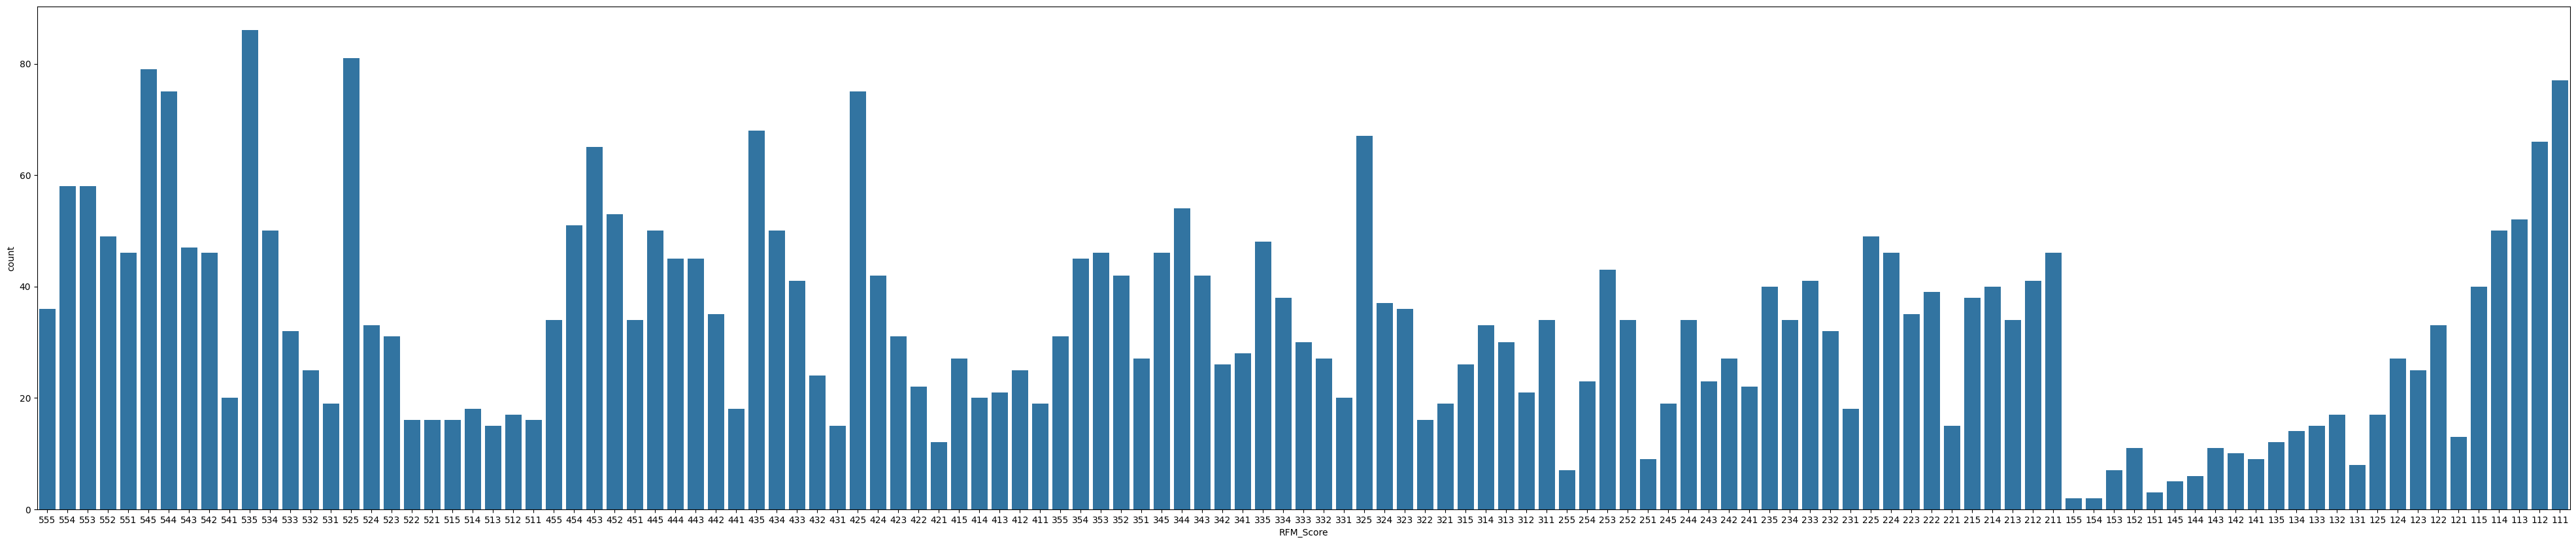

In [ ]:
plt.figure(figsize = (50,10))
sns.countplot(data = df_rfm, x = 'RFM_Score')

In [ ]:
# 세그먼트별 평균 RFM 값 계산
segment_stats = df_rfm.groupby('RFM_Score').agg({
    'purchase_frequency': 'mean',
    'monetary': ['mean', 'count'],
    'purchase_elapsed_days': 'mean'
}).reset_index()

segment_stats.columns = ['RFM_Score', 'Customer_Count', 'Average_Recency', 'Average_Frequency', 'Average_Monetary']
segment_stats


,RFM_Score,Customer_Count,Average_Recency,Average_Frequency,Average_Monetary
0,111,22.675325,1576.045714,77,568.350649
1,112,35.969697,5339.041894,66,552.621212
2,113,44.615385,7998.308750,52,542.769231
3,114,40.200000,11799.698300,50,533.060000
4,115,42.000000,17043.354250,40,558.525000
...,...,...,...,...,...
120,551,442.978261,2569.509348,46,29.804348
121,552,411.612245,5377.155510,49,32.163265
122,553,403.241379,8388.493190,58,32.810345
123,554,374.620690,11727.536466,58,32.379310


In [ ]:
#최근성, 구매 빈도, 금액 모두에서 높은 점수를 받은 555 고객을 추출
df_rfm_555 = df_rfm[df_rfm['RFM_Score'] == '555']
df_rfm_555_cust_id = df_rfm[df_rfm['RFM_Score'] == '555']['cust_id']
df_rfm_555

,cust_id,purchase_elapsed_days,purchase_frequency,monetary,Gender,city_code,age,age_group,R_Score,F_Score,M_Score,RFM_Score
3677,272809,28,307.0,15611.440,M,7.0,38,"[34, 39)",5,5,5,555
2863,271479,37,284.0,25870.260,F,6.0,27,"[24, 29)",5,5,5,555
3042,271771,24,328.0,14163.890,M,10.0,21,"[19, 24)",5,5,5,555
514,267643,37,296.0,15790.450,M,3.0,34,"[34, 39)",5,5,5,555
708,267965,41,260.0,16081.065,M,6.0,28,"[24, 29)",5,5,5,555
2651,271139,5,272.0,17036.890,M,2.0,37,"[34, 39)",5,5,5,555
4709,274510,45,353.0,14020.240,F,6.0,33,"[29, 34)",5,5,5,555
4873,274780,27,280.0,17287.725,M,6.0,38,"[34, 39)",5,5,5,555
4136,273553,3,262.0,17949.620,M,3.0,38,"[34, 39)",5,5,5,555
3498,272520,33,488.0,14310.855,M,5.0,35,"[34, 39)",5,5,5,555


## 고가치고객의 인구통계학적 특성 분석
* RFM 점수가 555인 고객을 고가치 고객으로 정의한다.
* 고가치 고객은 2.0, 5.0 지역에 많이 분포하고 있으므로, 이 지역에 오프라인몰 추가 투자를 계획해볼 수 있다.
* 고가치 고객은 34세 이상 39세 미만의 연령대에 많이 분포하고 있으므로, 해당 연령대를 타겟팅한 프로모션 혹은 프리미엄 제품 출시를 계획해볼 수 있다.
* 고가치 고객의 성별은 남성, 여성 각각 18명씩 존재하는 것으로 나타났다.

<Axes: xlabel='city_code', ylabel='count'>

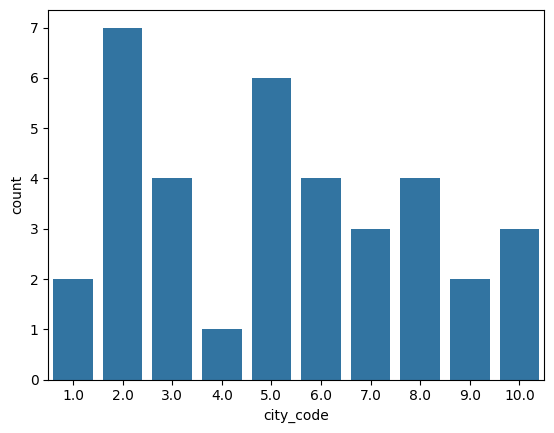

In [ ]:
sns.countplot(data = df_rfm_555, x = 'city_code')

<Axes: xlabel='age_group', ylabel='count'>

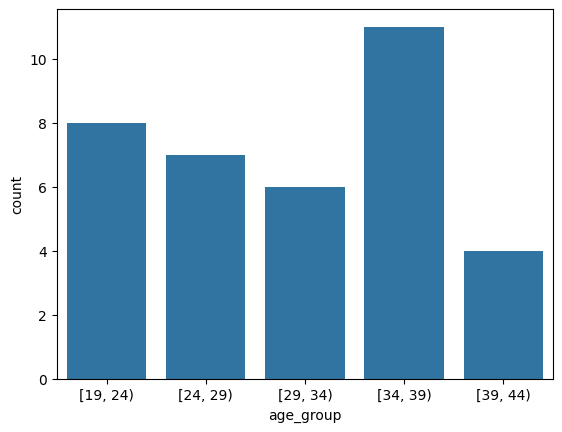

In [ ]:
sns.countplot(data = df_rfm_555, x = 'age_group')

<Axes: xlabel='Gender', ylabel='count'>

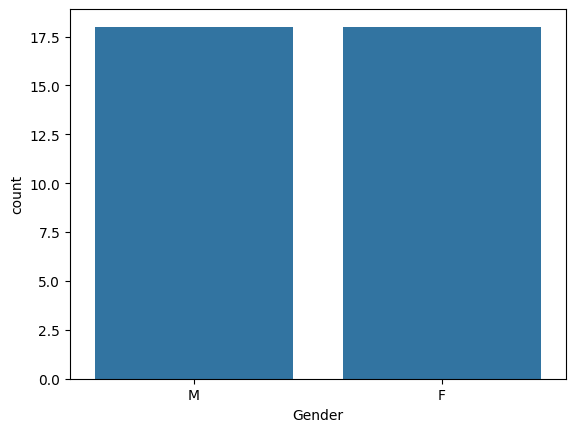

In [ ]:
sns.countplot(data = df_rfm_555, x = 'Gender')

In [ ]:
df_rfm_555.groupby('Gender').count()['cust_id']

Gender
F    18
M    18
Name: cust_id, dtype: int64

## 고가치 고객이 선호하는 제품/카테고리 분석 및 구매 증대 방안
* 고가치 고객 그룹과 아닌 그룹의 구매 횟수당 매출액의 차이가 가장 큰 카테고리는 리빙용품 및 주방용품(Home And Kitchen)으로 나타났다.
* 이는 고가치 고객의 주 연령층인 34~39세에 결혼/독립 등 생애주기의 변화를 맞으면서 리빙용품 및 주방용품의 구매가 늘어나는 것으로 보인다.

 (출처 : https://www.koit.co.kr/news/articleView.html?idxno=114598)
* 고가치 고객의 리빙용품 및 주방용품 매출액은 2011, 2013, 2014년의 경우 2~3월 전후로 가장 높았다.

  (2012년 2~3월은 구매가 없었던 것으로 보이는데, 해당 부분에 대한 추가 분석이 필요하다.)
* 그러므로, 매년 2~3월 해당 연령층을 타겟팅하여 신혼부부/1인가구를 위한 프로모션 등을 계획하여 고객 충성도를 높일 수 있다.

In [ ]:
#고가치그룹 여부 구분 컬럼을 추가하여 아닌 그룹과의 차이 비교
rfm_555_cust_id = df_rfm_555['cust_id'].tolist()
df_transaction_cat['High_Value_Customer'] = df_transaction_cat['cust_id'].apply(lambda x: 'Yes' if x in rfm_555_cust_id else 'No')


In [ ]:
df_transaction_cat['High_Value_Customer'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
df_transaction_cat

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,weekday,tran_year_month,prod_cat,prod_subcat,High_Value_Customer
0,80712190438,270351,2014-02-28,1,1,-5,-772,405.300,-4265.300,e-Shop,Friday,2014-02,Clothing,Women,No
1,29258453508,270384,2014-02-27,5,3,-5,-1497,785.925,-8270.925,e-Shop,Thursday,2014-02,Electronics,Computers,No
2,51750724947,273420,2014-02-24,6,5,-2,-791,166.110,-1748.110,TeleShop,Monday,2014-02,Books,DIY,No
3,93274880719,271509,2014-02-24,11,6,-3,-1363,429.345,-4518.345,e-Shop,Monday,2014-02,Home and kitchen,Bath,No
4,51750724947,273420,2014-02-23,6,5,-2,-791,166.110,-1748.110,TeleShop,Sunday,2014-02,Books,DIY,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23048,94340757522,274550,2011-01-25,12,5,1,1264,132.720,1396.720,e-Shop,Tuesday,2011-01,Books,Academic,No
23049,89780862956,270022,2011-01-25,4,1,1,677,71.085,748.085,e-Shop,Tuesday,2011-01,Clothing,Mens,No
23050,85115299378,271020,2011-01-25,2,6,4,1052,441.840,4649.840,MBR,Tuesday,2011-01,Home and kitchen,Furnishing,No
23051,72870271171,270911,2011-01-25,11,5,3,1142,359.730,3785.730,TeleShop,Tuesday,2011-01,Books,Children,No


In [ ]:
# 고객별 총 구매액 및 구매 횟수 계산
customer_sales = df_transaction_cat.groupby(['High_Value_Customer', 'cust_id']).agg(
    total_sales=('total_amt', 'sum'),
    purchase_count=('cust_id', 'count')
).reset_index()

# 고가치 고객 여부별 총 구매액 및 총 구매 횟수 계산
total_sales_and_purchases = customer_sales.groupby('High_Value_Customer').agg(
    total_sales=('total_sales', 'sum'),
    total_purchases=('purchase_count', 'sum')
).reset_index()

# 1구매당 평균 구매액 계산
total_sales_and_purchases['avg_sales_per_purchase'] = total_sales_and_purchases['total_sales'] / total_sales_and_purchases['total_purchases']

# 결과 출력
total_sales_and_purchases



,High_Value_Customer,total_sales,total_purchases,avg_sales_per_purchase
0,No,4.796436e+07,22888,2095.611499
1,Yes,6.154154e+05,165,3729.790212


<Axes: xlabel='High_Value_Customer', ylabel='avg_sales_per_purchase'>

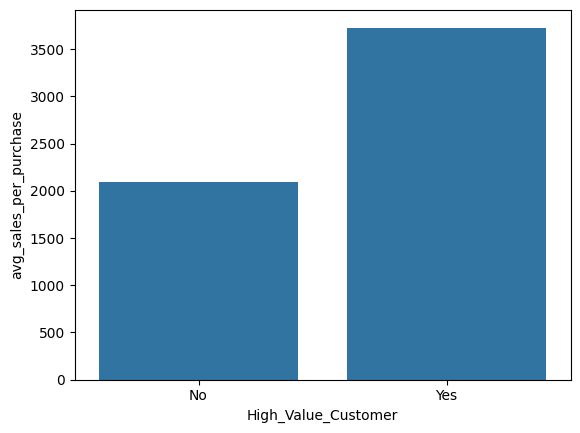

In [ ]:
sns.barplot(data = total_sales_and_purchases, x = 'High_Value_Customer', y = 'avg_sales_per_purchase')

In [ ]:
# 카테고리별, 고가치 고객 여부별 총 구매액 및 구매 횟수 계산
category_sales = df_transaction_cat.groupby(['prod_cat', 'High_Value_Customer']).agg(
    total_sales=('total_amt', 'sum'),
    purchase_count=('cust_id', 'count')
).reset_index()

# 1구매당 평균 구매액 계산
category_sales['avg_sales_per_purchase'] = category_sales['total_sales'] / category_sales['purchase_count']

# 결과 출력
category_sales


,prod_cat,High_Value_Customer,total_sales,purchase_count,avg_sales_per_purchase
0,Bags,No,4.078319e+06,1984,2055.604098
1,Bags,Yes,4.639011e+04,14,3313.579286
2,Books,No,1.269063e+07,6030,2104.582817
3,Books,Yes,1.320597e+05,39,3386.145000
4,Clothing,No,6.145362e+06,2936,2093.107108
5,Clothing,Yes,1.057750e+05,24,4407.292500
6,Electronics,No,1.060107e+07,4860,2181.290236
7,Electronics,Yes,1.213931e+05,38,3194.555000
8,Footwear,No,6.107598e+06,2971,2055.738132
9,Footwear,Yes,1.121763e+05,28,4006.295893


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Bags'),
  Text(1, 0, 'Books'),
  Text(2, 0, 'Clothing'),
  Text(3, 0, 'Electronics'),
  Text(4, 0, 'Footwear'),
  Text(5, 0, 'Home and kitchen')])

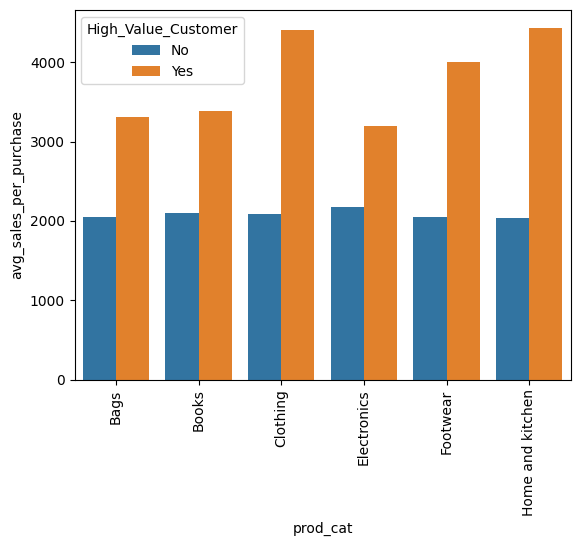

In [ ]:
#카테고리별 구매횟수당 구매액 분석
sns.barplot(data = category_sales, x = 'prod_cat', y = 'avg_sales_per_purchase', hue = 'High_Value_Customer')
plt.xticks(rotation = 90)

In [ ]:
pivot_category_sales = category_sales.pivot(index='prod_cat', columns='High_Value_Customer', values='avg_sales_per_purchase')

# 고가치 고객('Yes')과 그렇지 않은 고객('No')의 평균 구매액 차이 계산
pivot_category_sales['diff'] = pivot_category_sales['Yes'] - pivot_category_sales['No']

pivot_category_sales.sort_values(by = 'diff', ascending = False)

High_Value_Customer,No,Yes,diff
prod_cat,,,
Home and kitchen,2031.013408,4437.328409,2406.315001
Clothing,2093.107108,4407.292500,2314.185392
Footwear,2055.738132,4006.295893,1950.557761
Books,2104.582817,3386.145000,1281.562183
Bags,2055.604098,3313.579286,1257.975188
Electronics,2181.290236,3194.555000,1013.264764


<ipython-input-212-94836eebd14e>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data = df_transaction_cat[df_transaction_cat['prod_cat']=='Home and kitchen'], x = 'tran_date', y = 'total_amt', hue = 'High_Value_Customer', ci = None, marker = 'o')


<Axes: xlabel='tran_date', ylabel='total_amt'>

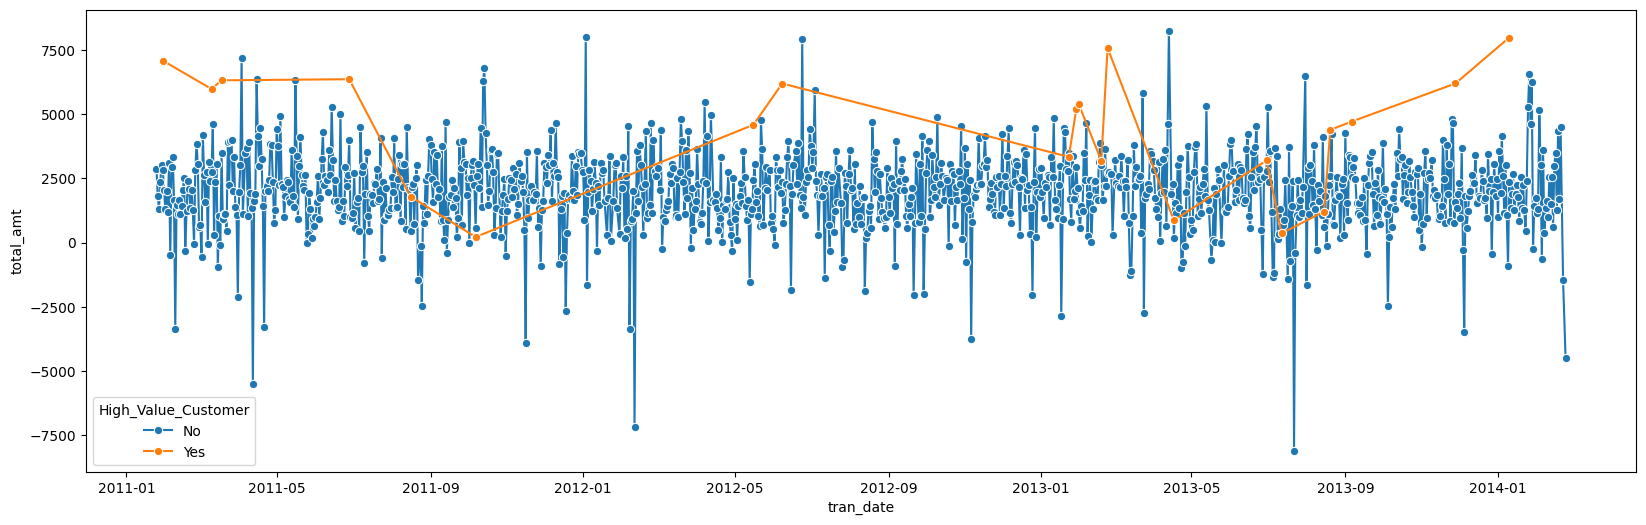

In [ ]:
#Home and kitchen 월별 구매 경향성 분석
plt.figure(figsize = (20,6))
sns.lineplot(data = df_transaction_cat[df_transaction_cat['prod_cat']=='Home and kitchen'], x = 'tran_date', y = 'total_amt', hue = 'High_Value_Customer', ci = None, marker = 'o')